# 01: Onshore layout-to-LCOE

In this example, we will demonstrate `Ard`'s ability to run a layout-to-LCOE analysis and optimization.

We can start by loading what we need to run the problem.

In [1]:
from pathlib import Path  # optional, for nice path specifications

import pprint as pp  # optional, for nice printing
import numpy as np  # numerics library
import matplotlib.pyplot as plt  # plotting capabilities

import ard  # technically we only really need this
from ard.utils.io import load_yaml  # we grab a yaml loader here
from ard.api import set_up_ard_model  # the secret sauce
from ard.viz.layout import plot_layout  # a plotting tool!

import openmdao.api as om  # for N2 diagrams from the OpenMDAO backend

%matplotlib inline

numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject

This will do for now.
We can probably make it a bit cleaner for a later release.

Now, we can set up a case.
We do it a little verbosely so that our documentation system can grab it, you can generally just use relative paths.
We grab the file at `inputs/ard_system.yaml`, which describes the `Ard` system for this problem.
It references, in turn, the `inputs/windio.yaml` file, which is where we define the plant we want to optimize, and an initial setup for it.

In [2]:
# load input
path_inputs = Path.cwd().absolute() / "inputs"
input_dict = load_yaml(path_inputs / "ard_system.yaml")

# create and setup system
prob = set_up_ard_model(input_dict=input_dict, root_data_path=path_inputs)

Adding top_level
Adding layout2aep
Adding layout to layout2aep
Adding aepFLORIS to layout2aep
	Activating approximate totals on layout2aep
Adding boundary
Adding landuse
Adding collection
Adding spacing_constraint
Adding tcc
Adding landbosse
Adding opex
Adding financese


Here, you should see each of the groups or components described as they are added to the `Ard` model and, occasionally, some options being turned on on them, like semi-total finite differencing on groups.

Next is some code you can flip on to use the [N2 diagram vizualization tools from the backend toolset, OpenMDAO, that we use](https://openmdao.org/newdocs/versions/latest/features/model_visualization/n2_basics/n2_basics.html).
This can be a really handy debugging tool, if somewhat tricky to use; turned on it will show a comprehensive view of the system in terms of its components, variables, and connections, although we leave it off for now.

In [3]:
if False:
    # visualize model
    om.n2(prob)

Now, we do a one-shot analysis.
The one-shot analysis will run a wind farm as specified in `inputs/windio.yaml` and with the models specified in `inputs/ard_system.yaml`, then dump the outputs.

In [4]:
# run the model
prob.run_model()

# collapse the test result data
test_data = {
    "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
    "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
    "BOS_val": float(prob.get_val("landbosse.total_capex", units="MUSD")[0]),
    "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
    "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
    "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
    "coll_length": float(prob.get_val("collection.total_length_cables", units="km")[0]),
    "turbine_spacing": float(
        np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
    ),
}

print("\n\nRESULTS:\n")
pp.pprint(test_data)
print("\n\n")



RESULTS:

{'AEP_val': 405.9510682648514,
 'BOS_val': 41.68227106807093,
 'CapEx_val': 110.5,
 'LCOE_val': 37.328810082644566,
 'OpEx_val': 3.7400000000000007,
 'area_tight': 13.2496,
 'coll_length': 21.89865877023397,
 'turbine_spacing': 0.91}





Now, we can optimize the same problem!
The optimization details are set under the `analysis_options` header in `inputs/ard_system.yaml`.
Here, we use a four-dimensional rectilinear layout parameterization ($\theta$) as design variables, constrain the farm such that the turbines are in the boundaries and satisfactorily spaced, and then we optimize for LCOE.
$$
\begin{aligned}
\textrm{minimize}_\theta \quad & \mathrm{LCOE}(\theta, \ldots) \\
\textrm{subject to} \quad & f_{\mathrm{spacing}}(\theta, \ldots) < 0 \\
                          & f_{\mathrm{boundary}}(\theta, \ldots) < 0
\end{aligned}
$$

In [5]:
optimize = True  # set to False to skip optimization
if optimize:
    # run the optimization
    prob.run_driver()
    prob.cleanup()

    # collapse the test result data
    test_data = {
        "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
        "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
        "BOS_val": float(prob.get_val("landbosse.total_capex", units="MUSD")[0]),
        "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
        "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
        "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
        "coll_length": float(
            prob.get_val("collection.total_length_cables", units="km")[0]
        ),
        "turbine_spacing": float(
            np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
        ),
    }

    # clean up the recorder
    prob.cleanup()

    # print the results
    print("\n\nRESULTS (opt):\n")
    pp.pprint(test_data)
    print("\n\n")

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|0
---------------------------------------------------------------
Design Vars
{'angle_orientation': array([0.]),
 'angle_skew': array([0.]),
 'spacing_primary': array([7.]),
 'spacing_secondary': array([7.])}

Objectives
{'financese.lcoe': array([0.03732881])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|1
---------------------------------------------------------------
Design Vars
{'angle_orientation': array([0.]),
 'angle_skew': array([0.]),
 'spacing_primary': array([7.]),
 'spacing_secondary': array([7.])}

Objectives
{'financese.lcoe': array([0.03732881])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|2
---------------------------------------------------------------
Design Vars
{'angle_orientation': array([0.]),
 'angle_skew': array([0.]),
 'spacing_primary': array([9.]),
 'spacing_secondary': array([7.])}

Objectives
{'financese.lcoe': array([0.03630168])}

Driver debug print for iter 

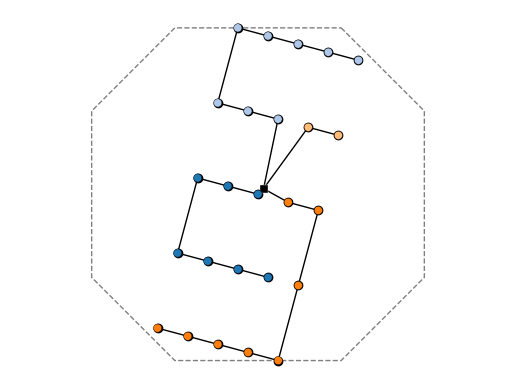

In [6]:
plot_layout(
    prob,
    input_dict=input_dict,
    show_image=True,
    include_cable_routing=True,
)
plt.show()

The result: a farm that fits in a stop-sign domain and minimzes the LCOE.